This notebook explores how collaborative relationships form between mailing list participants over time.

The hypothesis, loosely put, is that early exchanges are indicators of growing relationships or trust that should be reflected in information flow at later times.

In [1]:
%matplotlib inline

Next we'll import dependencies.

In [2]:
from bigbang.archive import Archive
import bigbang.parse as parse
import bigbang.graph as graph
import bigbang.mailman as mailman
import bigbang.process as process
import bigbang.twopeople as twoppl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from pprint import pprint as pp
import pytz
import math

Let's begin with just one mailing list to simplify.

In [3]:
url = "ncuc-discuss"
arx= Archive(url,archive_dir="../archives")

/home/gogol/Data/bigbang/bigbang/archive.py:74: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  self.data.sort(columns='Date', inplace=True)


In [4]:
arx.data.irow(0).Body

/home/gogol/Data/Anaconda2/envs/bigbang/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
  if __name__ == '__main__':


'Dear fellow members:\n\n\nAs you may know, and according to the following Resolution\n\nhttp://ncdnhc.icann-ncc.org/docs/resolution/resolution1.html\n\nThe members of the NCDNHC has time until Friday 17 to post their\nResolution Proposals.\n\nThe schedule would be the following:\n>From now to Friday 17:  Posting of Resolution Proposals by members\nFriday 18 - Wednesday 5: Discussion on Resolution Proposals\nFriday 7:  NCDNHC meeting in Montevideo\n\nPlease, take an action and send your Resolution Proposals!\n\nBest Regards\nVany\n\n--\nNilda Vany Martinez Grajales\nInformation Technology Specialist\nSustainable Development Networking Programme/Panama\ne-mail: vany at sdnp.org.pa\nhttp://www.sdnp.org.pa'

In [5]:
arx.data.shape

(18823, 6)

Let's look at the matrix of who replies to whom over the whole history of the list, to get a sense of the overall distribution

In [6]:
arx.data[arx.data['In-Reply-To'] > 0][:10]

,From,Subject,Date,In-Reply-To,References,Body
Message-ID,,,,,,
<5.0.2.1.0.20010817163107.00a46020@pop.wanadoo.fr>,jefsey at wanadoo.fr (Jefsey Morfin),[ncdnhc-discuss] Non-Commercial Supporting Org...,2001-08-17 14:50:19,<02eb01c12719$971b50e0$73296fd2@YJ>,None,"Bravo!\n\nDear YJ,\ncould it be thinkable that..."
<NEBBIKOECLBOEJKACPNDMEEGDHAA.achander@ucdavis.edu>,achander at ucdavis.edu (Anupam Chander),[ncdnhc-discuss] draft resolution on Intellect...,2001-08-22 20:37:45,<1A9EAC307DE9B647A6358AF9BA5E44E7192A36@exch1....,None,Thanks to Chris for some thought-provoking res...
<Pine.LNX.4.10.10108221643250.25169-100000@spitfire.law.miami.edu>,froomkin at law.miami.edu (Michael Froomkin - ...,[ncdnhc-discuss] draft resolution on Intellect...,2001-08-22 20:43:52,<1A9EAC307DE9B647A6358AF9BA5E44E7192A36@exch1....,None,I propose amending it to remain 50% of non-ex-...
<5.0.2.1.0.20010823104624.01f1f880@pop.wanadoo.fr>,jefsey at wanadoo.fr (Jefsey Morfin),[ncdnhc-discuss] draft resolution on Intellect...,2001-08-23 10:05:53,<NEBBIKOECLBOEJKACPNDMEEGDHAA.achander@ucdavis...,<1A9EAC307DE9B647A6358AF9BA5E44E7192A36@exch1....,"Dear Anupam,\nYour remark is of great interest..."
<5.0.2.1.0.20010823131343.028e08f0@pop.wanadoo.fr>,jefsey at wanadoo.fr (Jefsey Morfin),[ncdnhc-discuss] draft resolution on Intellect...,2001-08-23 11:20:01,<3B842C74.EE2ED657@dnsga.org>,<1A9EAC307DE9B647A6358AF9BA5E44E7192A36@exch1....,"Dear Derek,\nthe questions you rise are approp..."
<p05100301b7aa9d241bcd@[192.168.1.198]>,ajp at glocom.ac.jp (Adam Peake),[ncdnhc-discuss] business constituency on .ORG,2001-08-23 11:45:39,<5.0.2.1.0.20010823132101.01fca440@pop.wanadoo...,<5.0.2.1.0.20010823132101.01fca440@pop.wanadoo...,">Dear Adam,\n>The BC project is out of scope. ..."
<5.0.2.1.2.20010823104445.01c357c0@mail.msen.com>,weinberg at mail.msen.com (Jonathan Weinberg),[ncdnhc-discuss] business constituency on .ORG,2001-08-23 14:49:11,<p05100311b7aa6e0d5bd4@[192.168.1.198]>,None,"At 05:26 PM 8/23/2001 +0900, Adam Peake wrote:..."
<NEBBIKOECLBOEJKACPNDAEFLDHAA.achander@ucdavis.edu>,achander at ucdavis.edu (Anupam Chander),[ncdnhc-discuss] draft resolution on Intellect...,2001-08-23 22:07:58,<5.0.2.1.0.20010823104624.01f1f880@pop.wanadoo...,None,"Jeff,\n\nI assure you that I've read carefully..."
<5.0.2.1.0.20010824033303.00abfec0@pop.wanadoo.fr>,jefsey at wanadoo.fr (Jefsey Morfin),[ncdnhc-discuss] Re: NCDNHC solicitation of ca...,2001-08-24 03:39:17,<sb82a43f.066@gwia201.syr.edu>,None,"Dear NCDNHC Members,\nAs a candidate I want fi..."


In particular we are interested in who replied to who at each time. Recall that this is an open mailing list--everybody potentially reads each message. A response from A to B is an indication that A read B's original message. Therefore, a response indicates not just a single message from A to B, but an *exchange* from B to A and back again.

Below we modify our data to see who replied to whom.

In [7]:
messages = arx.data[['From']]

responses = arx.data[arx.data['In-Reply-To'] > 0][['From','Date','In-Reply-To']]

exchanges = pd.merge(messages,responses,how='inner',right_on='In-Reply-To',left_index=True,suffixes=['_original','_response'])

exchanges

,From_original,From_response,Date,In-Reply-To
Message-ID,,,,
<5.0.2.1.0.20010817163107.00a46020@pop.wanadoo.fr>,yjpark at myepark.com (YJ Park),jefsey at wanadoo.fr (Jefsey Morfin),2001-08-17 14:50:19,<02eb01c12719$971b50e0$73296fd2@YJ>
<NEBBIKOECLBOEJKACPNDMEEGDHAA.achander@ucdavis.edu>,CCHIU at aclu.org (Chris Chiu),achander at ucdavis.edu (Anupam Chander),2001-08-22 20:37:45,<1A9EAC307DE9B647A6358AF9BA5E44E7192A36@exch1....
<Pine.LNX.4.10.10108221643250.25169-100000@spitfire.law.miami.edu>,CCHIU at aclu.org (Chris Chiu),froomkin at law.miami.edu (Michael Froomkin - ...,2001-08-22 20:43:52,<1A9EAC307DE9B647A6358AF9BA5E44E7192A36@exch1....
<5.0.2.1.0.20010823104624.01f1f880@pop.wanadoo.fr>,achander at ucdavis.edu (Anupam Chander),jefsey at wanadoo.fr (Jefsey Morfin),2001-08-23 10:05:53,<NEBBIKOECLBOEJKACPNDMEEGDHAA.achander@ucdavis...
<5.0.2.1.0.20010823131343.028e08f0@pop.wanadoo.fr>,dconant at dnsga.org (Derek Conant),jefsey at wanadoo.fr (Jefsey Morfin),2001-08-23 11:20:01,<3B842C74.EE2ED657@dnsga.org>
<5.0.2.1.2.20010823104445.01c357c0@mail.msen.com>,ajp at glocom.ac.jp (Adam Peake),weinberg at mail.msen.com (Jonathan Weinberg),2001-08-23 14:49:11,<p05100311b7aa6e0d5bd4@[192.168.1.198]>
<NEBBIKOECLBOEJKACPNDAEFLDHAA.achander@ucdavis.edu>,jefsey at wanadoo.fr (Jefsey Morfin),achander at ucdavis.edu (Anupam Chander),2001-08-23 22:07:58,<5.0.2.1.0.20010823104624.01f1f880@pop.wanadoo...
<Pine.GSO.4.33.0108240056510.22349-100000@servidor.unam.mx>,Mueller at syr.edu (Milton Mueller),apisan at servidor.unam.mx (Alejandro Pisanty ...,2001-08-24 06:14:21,<sb851599.053@gwia201.syr.edu>
<5.0.2.1.0.20010827111056.026a38d0@pop.wanadoo.fr>,vandrome at renater.fr (Dany Vandromme),jefsey at wanadoo.fr (Jefsey Morfin),2001-08-27 10:56:32,<3B89DCE1.724B4E63@renater.fr>


In [8]:
exchanges.groupby(['From_original','From_response']).count()

Date  \
From_original                                      From_response                                              
Avri at ACM.ORG (Avri Doria)                       lectriclou at HOTMAIL.COM (Carl Smith)                 1   
Brett.Schaefer at heritage.org (Schaefer, Brett)   Margaret.Osborne at senecacollege.ca (Margaret ...     1   
                                                   njiemuhammed at gmail.com (Muhammed Njie)              1   
                                                   william.drake at uzh.ch (William Drake)                1   
CCHIU at aclu.org (Chris Chiu)                     abd at cdt.org (Alan Davidson)                         1   
                                                   achander at ucdavis.edu (Anupam Chander)               1   
                                                   ajp at glocom.ac.jp (Adam Peake)                       1   
                                                   dhc2 at dcrocker.net (Dave Crocker)                    4   
                                                   ehchun at peacenet.or.kr (Chun Eung Hwi)               1   
                                                   faia at amauta.rcp.net.pe (Erick Iriarte Ahon)         1   
                                                   fausett at lextext.com (Bret Fausett)                  1   
                                                   froomkin at law.miami.edu (Michael Froomkin - U...     1   
                                                   hakik at sdnbd.org (Hakikur Rahman)                    1   
                                                   marc at schneiders.org (Marc Schneiders)               1   
                                                   raul at inia.org.uy (Raul Echeberria)                  1   
                                                   terastra at terabytz.co.nz (Joop Teernstra)            2   
DNSO.Secretariat at dnso.org (DNSO Secretariat)    ehchun at peacenet.or.kr (Chun Eung Hwi)               1   
DannyYounger at cs.com (DannyYounger at cs.com)    ajp at glocom.ac.jp (Adam Peake)                       4   
                                                   apisan at servidor.unam.mx (Alejandro Pisanty -...     1   
                                                   dhc2 at dcrocker.net (Dave Crocker)                    1   
                                                   froomkin at law.miami.edu (Michael Froomkin - U...     1   
                                                   jefsey at club-internet.fr (J-F C. (Jefsey)  Mo...     1   
                                                   jefsey at wanadoo.fr (Jefsey Morfin)                   1   
                                                   jstyre at jstyre.com (James S. Tyre)                   1   
                                                   svensson at icannchannel.de (Alexander Svensson)       1   
                                                   tbyfield at panix.com (t byfield)                      1   
GendronM at mail.ccsu.edu (Gendron, Michael (MIS)) apisan at servidor.unam.mx (Alejandro Pisanty -...     1   
                                                   dhc2 at dcrocker.net (Dave Crocker)                    1   
                                                   jefsey at wanadoo.fr (Jefsey Morfin)                   1   
George.Sadowsky at attglobal.net (George Sadowsky) achander at ucdavis.edu (Anupam)                       1   
...                                                                                                     ...   
wsaqaf at gmail.com (Walid AL-SAQAF)               avri at acm.org (Avri Doria)                           1   
                                                   dafalla at yahoo.com (Hago Dafalla)                    1   
                                                   dafalla at yahoo.com (dafalla at yahoo.com)            1   
                                                   egmorris1 at toast.net (Edward Morris)                 1

The next step is to create a DataFrame that for each pair A and B:
* The duration of time between the first reply between that pair and the last.
* The total number of replies from A to B, $r_{AB}$, and from B to A, $r_{BA}$.
* The reciprocity of the conversation $min(r_{AB},r_{BA})/max(r_{AB},r_{BA})$

Using the exchanges data frame we can use the functions in twopeople.py to calculate the above quantities. The cell below gives a sample output for calculating duration, number of replies, and reciprocity for two specific contributers.   

In [10]:
twoppl.duration(exchanges, "oliphant at ee.byu.edu (Travis Oliphant)", "rossini at blindglobe.net (A.J. Rossini)"  )
twoppl.panda_pair(exchanges, "oliphant at ee.byu.edu (Travis Oliphant)", "rossini at blindglobe.net (A.J. Rossini)"  )

ValueError: max() arg is an empty sequence

The "duration" column gives us a datetime data structure so we must be careful later on when extracting information from this column. 

In [11]:
twoppl.duration(exchanges, "oliphant at ee.byu.edu (Travis Oliphant)", "rossini at blindglobe.net (A.J. Rossini)"  )

ValueError: max() arg is an empty sequence

Now let's create a dataframe that consists of these three quantities (duration, number of replies, and reciprocity) for each pair of contributers who interacted. 

To get all the unique pairs we can use the unique_pairs function in twopeople.py. This willl give us all pairs between any two individuals who had some degree of interation.

Note: The unique pairs we get back do not include reversed pairs. For example, if one of the pairs was ("Bob", "Mary"), we would not have ("Mary", "Bob") in our output.

In [12]:
pairs = twoppl.unique_pairs(exchanges)
pairs

{('ca at CAFONSO.CA (Carlos A. Afonso)',
  'edward.morris at ALUMNI.USC.EDU (Edward Morris)'),
 ('wendy at SELTZER.COM (Wendy Seltzer)',
  'deedeehalleck at GMAIL.COM (DeeDee Halleck)'),
 ('avri at acm.org (Avri Doria)',
  'tapani.tarvainen at effi.org (Tapani Tarvainen)'),
 ('deedeehalleck at GMAIL.COM (DeeDee Halleck)',
  'mok at HKNET.COM (Charles Mok)'),
 ('wjdrake at gmail.com (William Drake)', 'ca at cafonso.ca (Carlos Afonso)'),
 ('marc at schneiders.org (Marc Schneiders)',
  'dhc2 at dcrocker.net (Dave Crocker)'),
 ('ngarcia at ngarcia.net (Nuno Garcia)',
  'rsouza.rjo at gmail.com (Rogerio Mariano)'),
 ('william.drake at UZH.CH (William Drake)',
  'rusdiah at RAD.NET.ID (Rudi Rusdiah)'),
 ('milton at gatech.edu (Mueller, Milton L)',
  'wsaqaf at gmail.com (Walid AL-SAQAF)'),
 ('alain.berranger at GMAIL.COM (Alain Berranger)',
  'kdrstoll at GMAIL.COM (Klaus Stoll)'),
 ('robin at IPJUSTICE.ORG (Robin Gross)',
  'HughesDeb at USA.REDCROSS.ORG (Debra Hughes)'),
 ('robin at IPJUST

Using panda_allpairs, we can create the desired data frame

In [13]:
allpairs = twoppl.panda_allpairs(exchanges, pairs)
allpairs

,A,B,duration,num_replies,reciprocity
0,ca at CAFONSO.CA (Carlos A. Afonso),edward.morris at ALUMNI.USC.EDU (Edward Morris),0 days 00:24:25,2,1.000000
1,wendy at SELTZER.COM (Wendy Seltzer),deedeehalleck at GMAIL.COM (DeeDee Halleck),364 days 10:41:36,2,0.000000
2,avri at acm.org (Avri Doria),tapani.tarvainen at effi.org (Tapani Tarvainen),796 days 00:36:48,6,1.000000
3,deedeehalleck at GMAIL.COM (DeeDee Halleck),mok at HKNET.COM (Charles Mok),0 days 00:00:00,1,0.000000
4,wjdrake at gmail.com (William Drake),ca at cafonso.ca (Carlos Afonso),0 days 00:00:00,1,0.000000
5,marc at schneiders.org (Marc Schneiders),dhc2 at dcrocker.net (Dave Crocker),18 days 13:01:50,9,0.800000
6,ngarcia at ngarcia.net (Nuno Garcia),rsouza.rjo at gmail.com (Rogerio Mariano),0 days 00:00:00,1,0.000000
7,william.drake at UZH.CH (William Drake),rusdiah at RAD.NET.ID (Rudi Rusdiah),85 days 21:16:58,2,0.000000
8,"milton at gatech.edu (Mueller, Milton L)",wsaqaf at gmail.com (Walid AL-SAQAF),0 days 00:00:00,1,0.000000
9,alain.berranger at GMAIL.COM (Alain Berranger),kdrstoll at GMAIL.COM (Klaus Stoll),0 days 00:00:00,1,0.000000


The printed values below display the counts associated for a given number of replies.

We can see  that many of the interactions have a relatively small amount of replies. One possible explanation for this large amount may be having many interactions that are merely a follow-up or question followed by a thank you response (we can explore this further by parsing the message bodies in arx.data but for now we will just speculate). 

In [14]:
print "corresponding counts for number of replies up to 19"
print ("number of replies", "frequency of occurence")
for i in range(20):
    print (i, len(allpairs[allpairs['num_replies'] <= i]) - len(allpairs[allpairs['num_replies'] <= i - 1]))

corresponding counts for number of replies up to 19
('number of replies', 'frequency of occurence')
(0, 0)
(1, 1875)
(2, 573)
(3, 237)
(4, 146)
(5, 86)
(6, 68)
(7, 34)
(8, 38)
(9, 32)
(10, 18)
(11, 13)
(12, 18)
(13, 12)
(14, 9)
(15, 7)
(16, 6)
(17, 3)
(18, 2)
(19, 5)


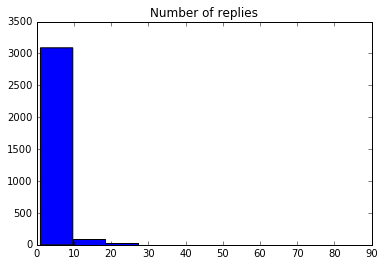

In [15]:
plt.hist(allpairs['num_replies'])
plt.title("Number of replies")

To get a better idea of what's going on for larger values, let's look at the rows that have number of replies greater than 5. 

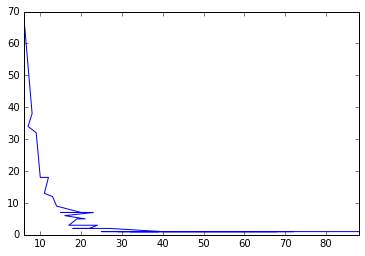

In [16]:
greaterThanFive = allpairs[allpairs['num_replies'] > 5]['num_replies']
counts = greaterThanFive.value_counts()
counts.plot()

The graph seems to follow a power law which is expected for this type of data. 

Now let's see if we can find any patters between the number of replies and reciprocity. Intuitively, we would expect that the number of replies be positively associated with reciprocity but let's see... 

We will first look at the data for which the number of replies is greater than 5 to possibly get rid of some noise (later on we will explore the data without removing these entries). 

Below we divided reciprocity and number of replies into completely arbitrary bins as shown below. Hopefully, this will make it easier to see patters between these two variables as they have quite a bit of noise. 

(The genId and genNumReplies functions just give each entry a corresponding label for graphing purposes later on. These labels are based on which bin a given entry falls under) 

In [17]:
#Completely arbitrary bins

#Group A reciprocity between (0, .25]
#Group B reciprocity between (.25, .5] 
#Group C reciprocity between (.5, .75]  
#Group D reciprocity between (.75, 1.00]

#"low" number of replies less than or equal to 10
#"moderate" number of replies between 10 and 20
#"high" replies greater than 20 replies 

def genId(num):
    if num <= .25:
        return 'A.(0, .25]'
    if num <= .5:
        return "B.(.25, .5]"
    if num <= .75:
        return "C.(.5, .75]"
    return "D.(.75, 1.00]"

def genNumReplies(num):
    if num <= 10:
        return 'a.low'
    if num <= 20:
        return "b.moderate"
    return "c.high"

The following lines generate a data frame that contains three columns:
1) Number of replies
2) Id corresponding to replies bin
3) Id corresponding to reciprocity bin

(The extra letters such as the a in "a.low" are just used so that pandas orders the columns in the way we want)

In [18]:
moreThanFive = allpairs[allpairs['num_replies'] > 5]
recipVec = moreThanFive['reciprocity']
numReplies = moreThanFive['num_replies']
ids = recipVec.apply(lambda val: genId(val))
groupedRep = numReplies.apply(lambda val: genNumReplies(val))
groupsdf = pd.DataFrame({"num_replies": numReplies, "ids": ids, "grouped_num_replies": groupedRep})
groupsdf


,grouped_num_replies,ids,num_replies
2,a.low,"D.(.75, 1.00]",6
5,a.low,"D.(.75, 1.00]",9
40,a.low,"D.(.75, 1.00]",9
43,b.moderate,"A.(0, .25]",12
66,a.low,"C.(.5, .75]",7
73,a.low,"C.(.5, .75]",8
85,a.low,"B.(.25, .5]",6
90,a.low,"A.(0, .25]",6
97,a.low,"A.(0, .25]",6
98,b.moderate,"D.(.75, 1.00]",13


Now that we have this data frame lets look at the corresponding histograms for each "level" of reciprocity.

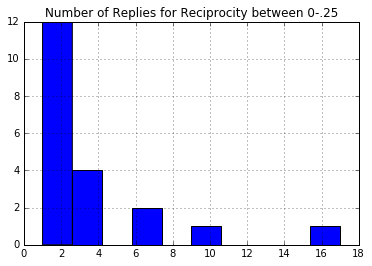

In [19]:

grpA = groupsdf[groupsdf["ids"] == "A.(0, .25]"]['num_replies']
grpB = groupsdf[groupsdf["ids"] == "B.(.25, .5]"]['num_replies']
grpC = groupsdf[groupsdf["ids"] == "C.(.5, .75]"]['num_replies']
grpD = groupsdf[groupsdf["ids"] == "D.(.75, 1.00]"]['num_replies']
grpA.value_counts().hist()
plt.title("Number of Replies for Reciprocity between 0-.25")

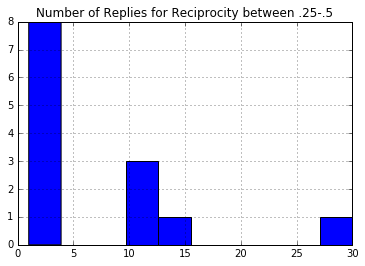

In [20]:
grpB.value_counts().hist()
plt.title("Number of Replies for Reciprocity between .25-.5")

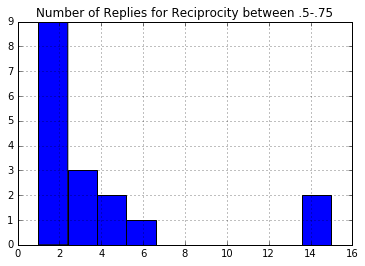

In [21]:
grpC.value_counts().hist()
plt.title("Number of Replies for Reciprocity between .5-.75")

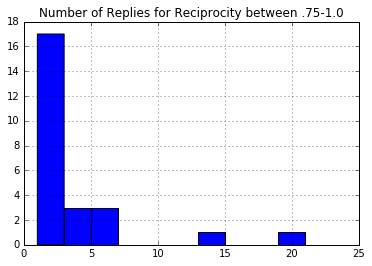

In [22]:
grpD.value_counts().hist()
plt.title("Number of Replies for Reciprocity between .75-1.0")

It's pretty hard to compare the four histograms so let's create a contingency table for the groupsdf data frame. 

In [23]:
crossed = pd.crosstab(groupsdf["grouped_num_replies"], groupsdf["ids"])
crossed

ids,"A.(0, .25]","B.(.25, .5]","C.(.5, .75]","D.(.75, 1.00]"
grouped_num_replies,,,,
a.low,42,67,34,47
b.moderate,16,18,26,22
c.high,7,6,6,15


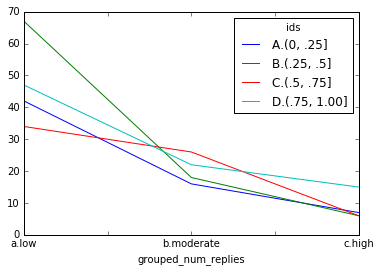

In [24]:
crossed.plot()

Since each reciprocity group has a different amount of counts, let's normalize the counts to get a better picture of what's going on. 

We will first normzalize column-wise, that is for say column A.[0,.25] we will sum the total number of responses and get the relative proportions for the replies bins. 

In [25]:
crossed.apply(lambda r: r/sum(r), axis=0)

ids,"A.(0, .25]","B.(.25, .5]","C.(.5, .75]","D.(.75, 1.00]"
grouped_num_replies,,,,
a.low,0.646154,0.736264,0.515152,0.559524
b.moderate,0.246154,0.197802,0.393939,0.261905
c.high,0.107692,0.065934,0.090909,0.178571


We see that at the very extremes, namely reciprocity between 0-.25 and reciprocity between .75-1.0, there are some clear differences; reciprocity seems to be positively associated with the number of replies as we had initially expected.

On the other hand, the bin for reciprocity between .25-.5 weakens this association as this bin seems as if it should swap positions with bin A. However, since the bin widths we chose were completely arbitrary it may explain this paradox. 

The fact that the extremes seem to follow our expectations is quite interesting; it provides some evidence that if we choose our bin sizes appropriately, we can perhaps get a nice positive association. 

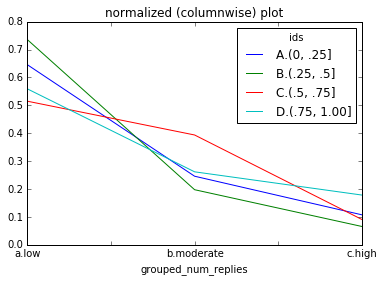

In [26]:
crossed.apply(lambda r: r/sum(r), axis=0).plot()
plt.title("normalized (columnwise) plot")

Now will do the normalization by row. This will give us the relative proportion of some bin for number of replies is distributed across the bins for reciprocity.

In [27]:
crossed.apply(lambda r: r/sum(r), axis=1)

ids,"A.(0, .25]","B.(.25, .5]","C.(.5, .75]","D.(.75, 1.00]"
grouped_num_replies,,,,
a.low,0.221053,0.352632,0.178947,0.247368
b.moderate,0.195122,0.219512,0.317073,0.268293
c.high,0.205882,0.176471,0.176471,0.441176


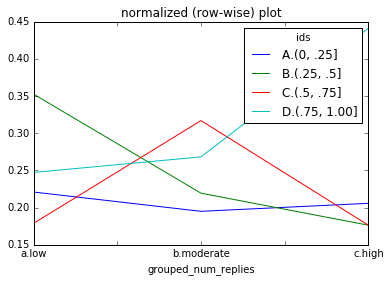

In [28]:
crossed.apply(lambda r: r/sum(r), axis=1).plot()
plt.title("normalized (row-wise) plot")

Now let's go back and do the exact same thing but not removing entries with a very low amount of replies. 

In [29]:
recipVec2 = allpairs['reciprocity']
numReplies2 = allpairs['num_replies']
ids = recipVec2.apply(lambda val: genId(val))
groupedRep2 = numReplies2.apply(lambda val: genNumReplies(val))
groupsdf2 = pd.DataFrame({"num_replies": numReplies2, "ids": ids, "grouped_num_replies": groupedRep2})

In [30]:
crossed2 = pd.crosstab(groupsdf2["grouped_num_replies"], groupsdf2["ids"])
crossed2

ids,"A.(0, .25]","B.(.25, .5]","C.(.5, .75]","D.(.75, 1.00]"
grouped_num_replies,,,,
a.low,2331,290,83,403
b.moderate,16,18,26,22
c.high,7,6,6,15


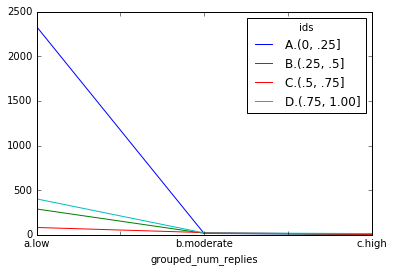

In [31]:
crossed2.plot()

In [32]:
crossed2.apply(lambda r: r/sum(r), axis=0)

ids,"A.(0, .25]","B.(.25, .5]","C.(.5, .75]","D.(.75, 1.00]"
grouped_num_replies,,,,
a.low,0.990229,0.923567,0.721739,0.915909
b.moderate,0.006797,0.057325,0.226087,0.050000
c.high,0.002974,0.019108,0.052174,0.034091


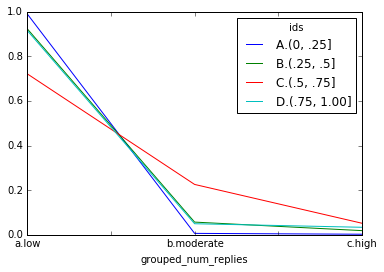

In [33]:
crossed2.apply(lambda r: r/sum(r), axis=0).plot()

Now we will look at various scatterplots for different variables to get a rough sense of how our data is spread. 

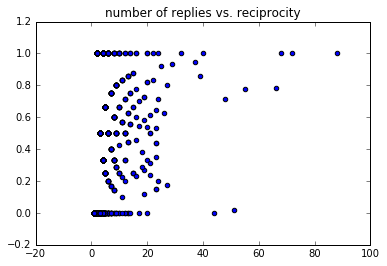

In [34]:
plt.scatter(allpairs.num_replies, allpairs.reciprocity)
plt.title("number of replies vs. reciprocity")

In [35]:
allpairs['duration'] = allpairs['duration'].apply(lambda x: x.item() / pow(10,9))
plt.scatter(allpairs.duration, allpairs.num_replies)
plt.title("duration vs. number of replies")

AttributeError: 'Timedelta' object has no attribute 'item'

Now let's look at some scatterplots for the entries with number of replies greater than 5.

TypeError: invalid type promotion

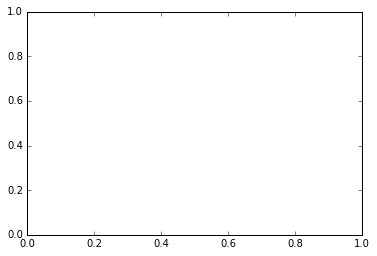

In [36]:
df_filt = allpairs[allpairs['num_replies'] > 5]
plt.scatter(df_filt.reciprocity, df_filt.duration)
plt.title("reciprocity vs. duration")

In [37]:
plt.scatter(df_filt.reciprocity, df_filt.duration.apply(lambda x: math.log(x)))
plt.title("reciprocity vs. log of duration")

TypeError: a float is required

In [38]:
plt.scatter(df_filt.duration.apply(lambda x: math.log(x+1)), df_filt.num_replies.apply(lambda x: math.log(x+1)))
plt.title("log of duration vs. log of number of replies")

TypeError: unsupported operand type(s) for +: 'Timedelta' and 'int'

Since we actually have the bodies of each message, we will now procceed by seeing if there are any patterns between the type of messages sent and reciprocity, duration, and the number of replies. 

As a very rough measure, we have created a function calMessageLen that calculates the length of a given message. 

In [39]:
def calMessageLen(message):
    if message == None:
        return 0
    return len(message)

arx.data['length'] = arx.data['Body'].apply(lambda x: calMessageLen(x))
arx.data

,From,Subject,Date,In-Reply-To,References,Body,length
Message-ID,,,,,,,
<3B77EDB8.E8A19089@sdnp.org.pa>,vany at sdnp.org.pa (Nilda Vany Martinez Graja...,[ncdnhc-discuss] Period for Resolution Proposals,2001-08-13 15:09:44,None,None,"Dear fellow members:\n\n\nAs you may know, and...",686
<3B77F3AB.C89FB4FC@sdnp.org.pa>,vany at sdnp.org.pa (Nilda Vany Martinez Graja...,[ncdnhc-discuss] [Fwd: ccTLD meeting on 7th Se...,2001-08-13 15:35:07,None,None,Hi to all:\n\nFYI\n\nBest Regards\nVany\n\n---...,1153
<02eb01c12719$971b50e0$73296fd2@YJ>,yjpark at myepark.com (YJ Park),[ncdnhc-discuss] Non-Commercial Supporting Org...,2001-08-17 12:38:56,None,None,"August. 17, 2001\n\nYJ Park\n\n\n ...",1842
<5.0.2.1.0.20010817163107.00a46020@pop.wanadoo.fr>,jefsey at wanadoo.fr (Jefsey Morfin),[ncdnhc-discuss] Non-Commercial Supporting Org...,2001-08-17 14:50:19,<02eb01c12719$971b50e0$73296fd2@YJ>,None,"Bravo!\n\nDear YJ,\ncould it be thinkable that...",4035
<sb7d21b7.024@gwia201.syr.edu>,Mueller at syr.edu (Milton Mueller),[ncdnhc-discuss] Re: [ncdnhc-adcom] Non-Commer...,2001-08-17 17:52:51,None,None,YJ:\nI don't think we have the political suppo...,2531
<014401c12795$15be7be0$73296fd2@YJ>,yjpark at myepark.com (YJ Park),[ncdnhc-discuss] Re: [ncdnhc-adcom] Non-Commer...,2001-08-18 03:23:00,None,<sb7d21b7.025@gwia201.syr.edu>,"Milton,\n\n> I don't think we have the politic...",3533
<3B7DF87B.41EE6ACB@renater.fr>,vandrome at renater.fr (Dany Vandromme),[ncdnhc-discuss] Re: [ncdnhc-adcom] Non-Commer...,2001-08-18 05:09:16,None,<sb7d21b7.024@gwia201.syr.edu>,Milton Mueller wrote:\n> \n> YJ:\n> I don't th...,3370
<sb82a43f.063@gwia201.syr.edu>,Mueller at syr.edu (Milton Mueller),[ncdnhc-discuss] NCDNHC solicitation of candid...,2001-08-21 22:10:40,None,None,Dear prospective Board members: \nOn behalf of...,2364
<1A9EAC307DE9B647A6358AF9BA5E44E7192A36@exch1.NYNational.local>,CCHIU at aclu.org (Chris Chiu),[ncdnhc-discuss] draft resolution on Intellect...,2001-08-22 20:24:35,None,None,Non-Commercial Constituency Resolution \non In...,914
